In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import scipy.integrate as spi
import h5py
import os

from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

In [2]:
file_path = '/fred/oz009/cpower/TheThreeHundred/NewMDCLUSTER_001/GIZMO_7k-NewMDCLUSTER_001.snap_128.z0.000.AHF_halos'
with open(file_path, 'r') as file:
    print(file.readline())  

#ID(1)	hostHalo(2)	numSubStruct(3)	Mhalo(4)	npart(5)	Xc(6)	Yc(7)	Zc(8)	VXc(9)	VYc(10)	VZc(11)	Rhalo(12)	Rmax(13)	r2(14)	mbp_offset(15)	com_offset(16)	Vmax(17)	v_esc(18)	sigV(19)	lambda(20)	lambdaE(21)	Lx(22)	Ly(23)	Lz(24)	b(25)	c(26)	Eax(27)	Eay(28)	Eaz(29)	Ebx(30)	Eby(31)	Ebz(32)	Ecx(33)	Ecy(34)	Ecz(35)	ovdens(36)	nbins(37)	fMhires(38)	Ekin(39)	Epot(40)	SurfP(41)	Phi0(42)	cNFW(43)	n_gas(44)	M_gas(45)	lambda_gas(46)	lambdaE_gas(47)	Lx_gas(48)	Ly_gas(49)	Lz_gas(50)	b_gas(51)	c_gas(52)	Eax_gas(53)	Eay_gas(54)	Eaz_gas(55)	Ebx_gas(56)	Eby_gas(57)	Ebz_gas(58)	Ecx_gas(59)	Ecy_gas(60)	Ecz_gas(61)	Ekin_gas(62)	Epot_gas(63)	n_star(64)	M_star(65)	lambda_star(66)	lambdaE_star(67)	Lx_star(68)	Ly_star(69)	Lz_star(70)	b_star(71)	c_star(72)	Eax_star(73)	Eay_star(74)	Eaz_star(75)	Ebx_star(76)	Eby_star(77)	Ebz_star(78)	Ecx_star(79)	Ecy_star(80)	Ecz_star(81)	Ekin_star(82)	Epot_star(83)	mean_z_gas(84)	mean_z_star(85)	n_star_excised(86)	M_star_excised(87)	mean_z_star_excised(88)	



In [3]:
DM_density = np.loadtxt('./data/density_profiles_GIZMO_7k_DM.txt')
Gas_density = np.loadtxt('./data/density_profiles_GIZMO_7k_gas.txt')
Stars_density = np.loadtxt('./data/density_profiles_GIZMO_7k_stars.txt')
Gas_sph_density = np.loadtxt('./data/density_sph_profiles_GIZMO_7k_gas.txt')
Gas_entropy = np.loadtxt('./data/entropy_profiles_GIZMO_7k_gas.txt')
Gas_internalenergy = np.loadtxt('./data/internal_energy_profiles_GIZMO_7k_gas.txt')
M200_R200 = np.loadtxt('./data/cluster_M200_R200_GIZMO_7k_snap128.txt')
Properties = np.loadtxt('./data/cluster_properties_GIZMO_7k_snap128.txt')

print(DM_density.shape,Gas_density.shape,Stars_density.shape,Gas_sph_density.shape,Gas_entropy.shape,Gas_internalenergy.shape
     ,M200_R200.shape, Properties.shape)

(324, 100) (324, 100) (324, 100) (324, 100) (324, 100) (324, 100) (324, 2) (324, 86)


/tmp/ipykernel_1795001/1809563224.py:18: RuntimeWarning: invalid value encountered in log
  log_D = np.log(smoothed_density)


1.873817422860385


(-6.8, 3.0)

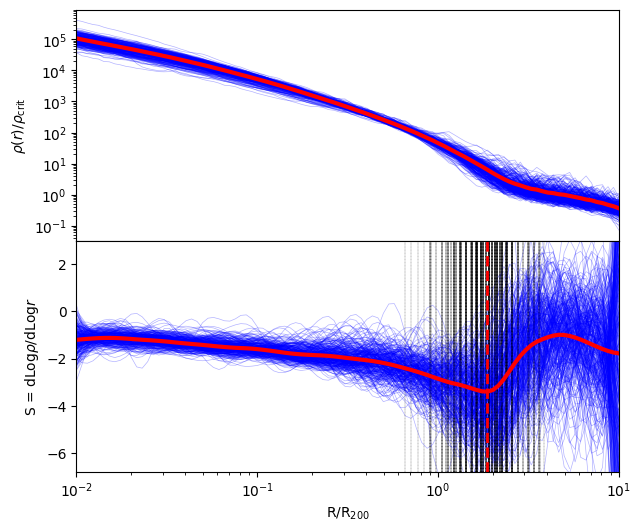

In [4]:
# DM density profile
Rsp=[]
rhonorm=2.7753662724817174e-08#*0.6777**2
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple', 'brown']
start = 0.01
end = 10
log_bins = np.logspace(np.log10(start), np.log10(end), 100)

fig = plt.figure(figsize=(7, 6))
fig.subplots_adjust(hspace=0.0)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

for i in range(DM_density.shape[0]):
# for i in range(10):
    ax1.plot(log_bins, DM_density[i]/rhonorm, color='blue',linewidth=0.5, alpha=0.3)
    smoothed_density = savgol_filter(DM_density[i], window_length=15, polyorder=4, deriv=0, delta=0.1)
    log_D = np.log(smoothed_density)
    log_r = np.log(log_bins)
    d_log_D = np.gradient(log_D, log_r)   
    # ax2.plot(log_bins, d_log_D, color='blue', linestyle='-', linewidth=2.0)
    smoothed_d_log_D = savgol_filter(d_log_D, window_length=15, polyorder=4, deriv=0, delta=0.01)
    ax2.plot(log_bins, smoothed_d_log_D, color='blue', linestyle='-', linewidth=0.5, alpha=0.3) # colors[i % len(colors)]
    
    restricted_indices = np.where((log_bins >= 0.5) & (log_bins <= 4))[0]
    rr = log_bins[restricted_indices]
    smoothed_d_log_D_restricted = smoothed_d_log_D[restricted_indices]
    
    r_splash_index = np.argmin(smoothed_d_log_D_restricted)
    r_splash = rr[r_splash_index]

    interp_func = interp1d(log_bins, smoothed_d_log_D, kind='cubic')
    log_bins_dense = np.linspace(r_splash-0.1, r_splash+0.1, 1000)
    smoothed_d_log_D_dense = interp_func(log_bins_dense)
    max_index = np.argmax(smoothed_d_log_D_dense)
    r_splash = log_bins_dense[max_index]

    Rsp.append(r_splash)
    ax2.axvline(x=r_splash, color='black', linestyle='--', linewidth=0.2)

mean_DM_density = np.mean(DM_density, axis=0)
ax1.plot(log_bins, mean_DM_density/rhonorm, color='red', linewidth=3.0, alpha=1)

smoothed_density = savgol_filter(mean_DM_density, window_length=15, polyorder=4, deriv=0, delta=0.1)
log_D = np.log(smoothed_density)
log_r = np.log(log_bins)
d_log_D = np.gradient(log_D, log_r)   
smoothed_d_log_D = savgol_filter(d_log_D, window_length=15, polyorder=4, deriv=0, delta=0.01)
ax2.plot(log_bins, smoothed_d_log_D, color='r', linestyle='-', linewidth=3.0) # colors[i % len(colors)]
restricted_indices = np.where((log_bins >= 0.5) & (log_bins <= 4))[0]
rr = log_bins[restricted_indices]
smoothed_d_log_D_restricted = smoothed_d_log_D[restricted_indices]
r_splash_index = np.argmin(smoothed_d_log_D_restricted)
r_splash = rr[r_splash_index]
ax2.axvline(x=r_splash, color='r', linestyle='--', linewidth=2.0)
print(r_splash)

ax1.set_ylabel(r'$\rho(r)/\rho_{\rm crit}$') #{\rm Log}_{10} 
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(0.01,10)
ax1.get_xaxis().set_visible(False)

ax2.set_xscale('log')
# ax2.set_yscale('log')
ax2.set_xlabel(r'${\rm R/R}_{200}$')
ax2.set_ylabel(r'S = ${\rm d Log} \rho / {\rm d Log} r$')
ax2.set_xlim(0.01,10)
ax2.set_ylim(-6.8,3)

2.4770763559917115


(-6.0, 3.5)

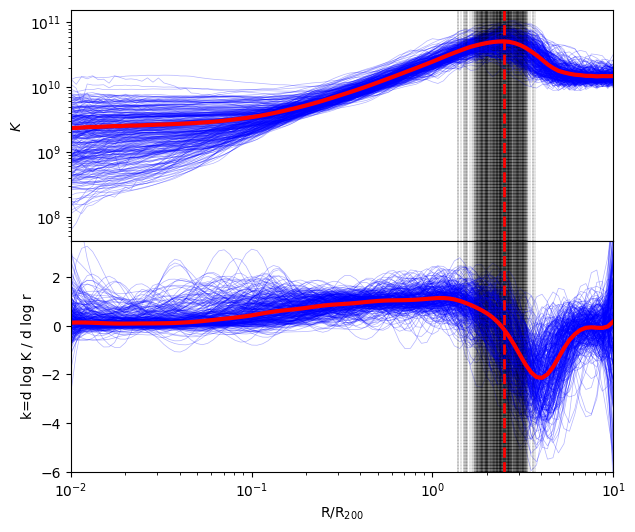

In [5]:
# Gas entropy profile
Rsh=[]
fig = plt.figure(figsize=(7, 6))
fig.subplots_adjust(hspace=0.0)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

for i in range(Gas_entropy.shape[0]):
# for i in range(10):
    ax1.plot(log_bins, Gas_entropy[i], color='blue',linewidth=0.5, alpha=0.3)
    smoothed_entropy = savgol_filter(Gas_entropy[i], window_length=15, polyorder=4, deriv=0, delta=0.1)
    log_D = np.log(smoothed_entropy)
    log_r = np.log(log_bins)
    d_log_D = np.gradient(log_D, log_r)   
    # ax2.plot(log_bins, d_log_D, color='blue', linestyle='-', linewidth=2.0)
    smoothed_d_log_D = savgol_filter(d_log_D, window_length=15, polyorder=4, deriv=0, delta=0.01)
    ax2.plot(log_bins, smoothed_d_log_D, color='blue', linestyle='-', linewidth=0.5, alpha=0.3) # colors[i % len(colors)]

    r_range_mask = (log_bins >= 1) & (log_bins <= 5)
    rgav_1_in_range = log_bins[r_range_mask]
    umed_av_in_range = smoothed_entropy[r_range_mask]
    
    if len(umed_av_in_range) > 0:
        max_entropy_index = np.argmax(umed_av_in_range)
        r_shock = rgav_1_in_range[max_entropy_index]
        # ax1.axvline(x=r_shock, color='black', linestyle='--', linewidth=1)
        
        interp_func = interp1d(log_bins, smoothed_entropy, kind='cubic')
        log_bins_dense = np.linspace(r_shock-0.1, r_shock+0.1, 1000)
        smoothed_entropy_dense = interp_func(log_bins_dense)
        max_index = np.argmax(smoothed_entropy_dense)
        r_shock = log_bins_dense[max_index]
    
        ax1.axvline(x=r_shock, color='black', linestyle='--', linewidth=0.2)
        ax2.axvline(x=r_shock, color='black', linestyle='--', linewidth=0.2)
    Rsh.append(r_shock)

mean_Gas_entropy = np.mean(Gas_entropy, axis=0)
ax1.plot(log_bins, mean_Gas_entropy, color='r',linewidth=3.0, alpha=1)
smoothed_entropy = savgol_filter(mean_Gas_entropy, window_length=15, polyorder=4, deriv=0, delta=0.1)
log_D = np.log(smoothed_entropy)
log_r = np.log(log_bins)
d_log_D = np.gradient(log_D, log_r)   
smoothed_d_log_D = savgol_filter(d_log_D, window_length=15, polyorder=4, deriv=0, delta=0.01)
ax2.plot(log_bins, smoothed_d_log_D, color='r', linestyle='-', linewidth=3.0) # colors[i % len(colors)]
r_range_mask = (log_bins >= 1) & (log_bins <= 5)
rgav_1_in_range = log_bins[r_range_mask]
umed_av_in_range = smoothed_entropy[r_range_mask]
if len(umed_av_in_range) > 0:
    max_entropy_index = np.argmax(umed_av_in_range)
    r_shock = rgav_1_in_range[max_entropy_index]
ax1.axvline(x=r_shock, color='r', linestyle='--', linewidth=2)
ax2.axvline(x=r_shock, color='r', linestyle='--', linewidth=2)
print(r_shock)

ax1.set_ylabel(r'$K$') #/K_{200}
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(0.01,10)
ax1.get_xaxis().set_visible(False)

ax2.set_xlabel(r'${\rm R/R}_{200}$')
ax2.set_ylabel(r'k=d log K / d log r')
ax2.set_xscale('log')
# ax2.set_yscale('log')
ax2.set_xlim(0.01,10)
ax2.set_ylim(-6,3.5)

324 324
1.9215239567249702 2.4294323466158394 1.2643258170751845


(0.5, 5.2)

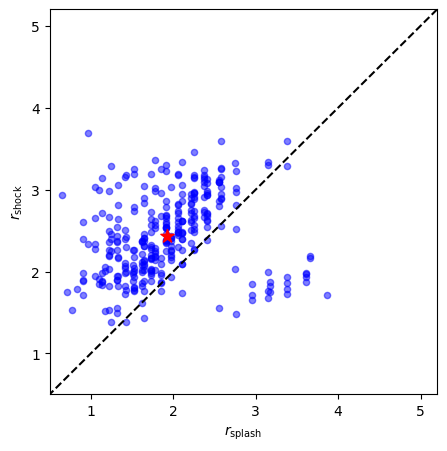

In [6]:
print(len(Rsp), len(Rsh))
fig = plt.figure(figsize=(5, 5))
plt.scatter(Rsp, Rsh, color='blue',s=20, alpha=0.5)
plt.scatter(np.mean(Rsp), np.mean(Rsh), color='r',s=100, marker='*')
print(np.mean(Rsp), np.mean(Rsh), np.mean(Rsh)/np.mean(Rsp))
plt.plot([0.1, 6], [0.1, 6], color='black', linestyle='--', label='1:1 line')

plt.xlabel(r'$r_{\rm splash}$')
plt.ylabel(r'$r_{\rm shock}$')
plt.xlim(0.5,5.2)
plt.ylim(0.5,5.2)
# plt.savefig("./figures/Rsplash_Rshock_324.png")

(0.0, 3.0)

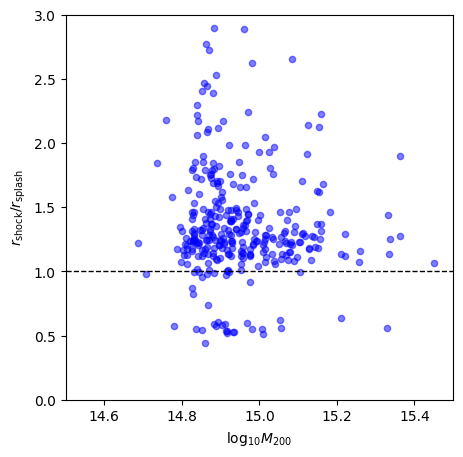

In [7]:
M200 = M200_R200[:,0]
fig = plt.figure(figsize=(5, 5))
plt.scatter(np.log10(M200), np.array(Rsh)/np.array(Rsp), color='blue',s=20, alpha=0.5)

plt.axhline(1, color='black', linestyle='--', linewidth=1)
# plt.scatter(np.mean(Rsp), np.mean(Rsh), color='r',s=100, marker='*')
# print(np.mean(Rsp), np.mean(Rsh), np.mean(Rsh)/np.mean(Rsp))
# plt.plot([0.1, 6], [0.1, 6], color='black', linestyle='--', label='1:1 line')

plt.ylabel(r'$r_{\rm shock}/r_{\rm splash}$')
plt.xlabel(r'log$_{10} M_{200}$')
plt.xlim(14.5,15.5)
plt.ylim(0,3)